In [1]:
import uproot4
import numpy as np
import numba
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
from coffea import hist
from coffea.processor import defaultdict_accumulator
import os
import copy

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

#Just to efficiently save plots
plot_dir = "plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

print("Saving plots to: ", save_path)

#Plot settings
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

## Data processing codes
def getData(fname="", treeName="Truth"):
    dq_dict = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "GenVertex": ak.zip({
                                            "x": dq_dict["gvx"],
                                            "y": dq_dict["gvy"],
                                            "z": dq_dict["gvz"],
                                            "px": dq_dict["gpx"],
                                            "py": dq_dict["gpy"],
                                            "pz": dq_dict["gpz"]

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict["gpx_st1"],
                                            "py": dq_dict["gpy_st1"],
                                            "pz": dq_dict["gpz_st1"],
                                            "x":dq_dict["gx_st1"],
                                            "y":dq_dict["gy_st1"],
                                            "z":dq_dict["gz_st1"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict["track_px_st1"],
                                            "py": dq_dict["track_py_st1"],
                                            "pz": dq_dict["track_pz_st1"],
                                            "x":  dq_dict["track_x_st1"],
                                            "y":  dq_dict["track_y_st1"],
                                            "z":  dq_dict["track_z_st1"],
                        }),
                        
                       }, depth_limit=1)
    return dq_events


######## READ EVENTS
filename = "ntuples/ApMuons_May262021.root"
dq_events = getData(filename)

Saving plots to:  plot/30-05-2021


## Comparing truth vertex and track reco info at Station 1

In [2]:
hists = {}

hists["x_ratio_truth"] = hist.Hist("Events",
                             hist.Bin("x_residual", r"$x_{st1~(reco)} - x_{vertex~(truth)}$ [cm]", 40, -10, 10),
                             hist.Bin("px", r"Truth Vertex $p_x$ [GeV]" , 40, 0, 3))
hists["y_ratio_truth"] = hist.Hist("Events",
                             hist.Bin("y_residual", r"$y_{st1~(reco)} - y_{vertex~(truth)}$ [cm]", 40, -10, 10),
                             hist.Bin("py", r"Truth Vertex $p_y$ [GeV]" , 40, 0, 3))
hists["z_ratio_truth"] = hist.Hist("Events",
                             hist.Bin("z_residual", r"$z_{st1~(reco)} - z_{vertex~(truth)}$ [cm]", 40, 0, 150),
                             hist.Bin("pz", r"Truth Vertex $p_z$ [GeV]" , 40, 0, 150))
#RECO
hists["x_ratio_reco"] = hist.Hist("Events",
                             hist.Bin("x_residual", r"$x_{st1~(reco)} - x_{vertex~(truth)}$ [cm]", 40, -10, 10),
                             hist.Bin("px", r"Reco St1 $p_x$ [GeV]" , 40, 0, 3))
hists["y_ratio_reco"] = hist.Hist("Events",
                             hist.Bin("y_residual", r"$y_{st1~(reco)} - y_{vertex~(truth)}$ [cm]", 40, -10, 10),
                             hist.Bin("py", r"Reco St1 $p_y$ [GeV]" , 40, 0, 3))
hists["z_ratio_reco"] = hist.Hist("Events",
                             hist.Bin("z_residual", r"$z_{st1~(reco)} - z_{vertex~(truth)}$ [cm]", 40, 0, 150),
                             hist.Bin("pz", r"Reco St1 $p_z$ [GeV]" , 40, 0, 150))

def processor(dq_events):
    
    GenMuonsVertex = dq_events["GenVertex"]
    RecoMuons = dq_events["Track_St1"]
    
    events_selected = ak.any(RecoMuons.pz, axis=1)
    RecoMuons_selected = RecoMuons[events_selected]
    GenMuonsVertex_selected = GenMuonsVertex[events_selected]
    
    # take the max so that no need to do matching
    # not always correct, but should work at leading order
    RecoMuons_selected_px_max = ak.max(RecoMuons_selected.px, axis=1)
    GenMuonsVertex_selected_px_max = ak.max(GenMuonsVertex_selected.px, axis=1)
    RecoMuons_selected_py_max = ak.max(RecoMuons_selected.py, axis=1)
    GenMuonsVertex_selected_py_max = ak.max(GenMuonsVertex_selected.py, axis=1)
    RecoMuons_selected_pz_max = ak.max(RecoMuons_selected.pz, axis=1)
    GenMuonsVertex_selected_pz_max = ak.max(GenMuonsVertex_selected.pz, axis=1)
    
    #Select the max momentum events in both station 1 and vertex to compare
    # to each other
    
    #X
    RecoX_selection = RecoMuons_selected.px >= ak.max(RecoMuons_selected.px, axis=1)[:,None]
    GenXVertex_selection = GenMuonsVertex_selected.px >= ak.max(GenMuonsVertex_selected.px, axis=1)[:,None]
    
    RecoMuons_selected_x = copy.deepcopy(RecoMuons_selected[RecoX_selection].x)
    GenMuonsVertex_selected_x = copy.deepcopy(GenMuonsVertex_selected[GenXVertex_selection].x)
    
    hists["x_ratio_truth"].fill(x_residual = ak.flatten(RecoMuons_selected_x - GenMuonsVertex_selected_x),
                               px = GenMuonsVertex_selected_px_max)
    
    hists["x_ratio_reco"].fill(x_residual = ak.flatten(RecoMuons_selected_x - GenMuonsVertex_selected_x),
                               px = RecoMuons_selected_px_max)
    
    #Y
    RecoY_selection = RecoMuons_selected.py >= ak.max(RecoMuons_selected.py, axis=1)[:,None]
    GenYVertex_selection = GenMuonsVertex_selected.py >= ak.max(GenMuonsVertex_selected.py, axis=1)[:,None]
    
    RecoMuons_selected_y = copy.deepcopy(RecoMuons_selected[RecoX_selection].y)
    GenMuonsVertex_selected_y = copy.deepcopy(GenMuonsVertex_selected[GenYVertex_selection].y)
    
    hists["y_ratio_truth"].fill(y_residual = ak.flatten(RecoMuons_selected_y - GenMuonsVertex_selected_y),
                               py = GenMuonsVertex_selected_py_max)
    
    hists["y_ratio_reco"].fill(y_residual = ak.flatten(RecoMuons_selected_y - GenMuonsVertex_selected_y),
                               py = RecoMuons_selected_py_max)
    
    #Z
    RecoZ_selection = RecoMuons_selected.pz >= ak.max(RecoMuons_selected.pz, axis=1)[:,None]
    GenZVertex_selection = GenMuonsVertex_selected.pz >= ak.max(GenMuonsVertex_selected.pz, axis=1)[:,None]
    
    RecoMuons_selected_z = copy.deepcopy(RecoMuons_selected[RecoZ_selection].z)
    GenMuonsVertex_selected_z = copy.deepcopy(GenMuonsVertex_selected[GenZVertex_selection].z)
    
    hists["z_ratio_truth"].fill(z_residual = ak.flatten(RecoMuons_selected_z - GenMuonsVertex_selected_z),
                               pz = GenMuonsVertex_selected_pz_max)
    
    hists["z_ratio_reco"].fill(z_residual = ak.flatten(RecoMuons_selected_z - GenMuonsVertex_selected_z),
                               pz = RecoMuons_selected_pz_max)

In [3]:
processor(dq_events)

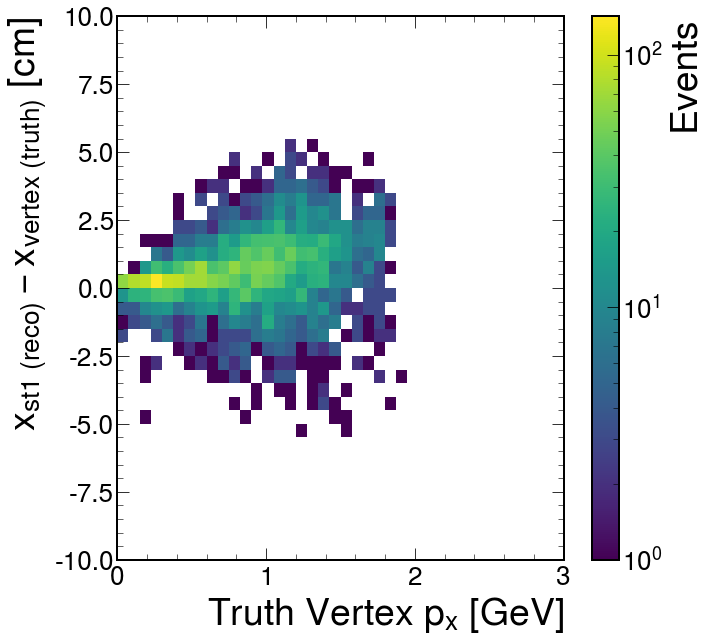

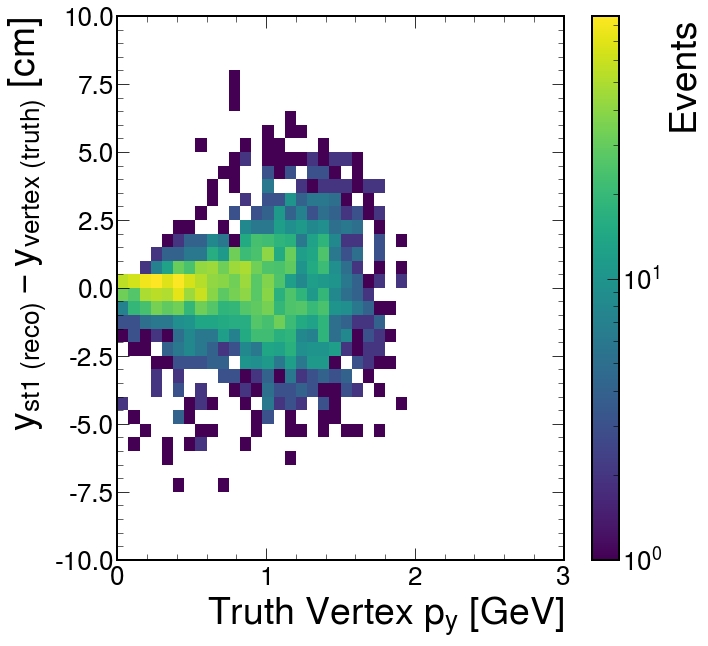

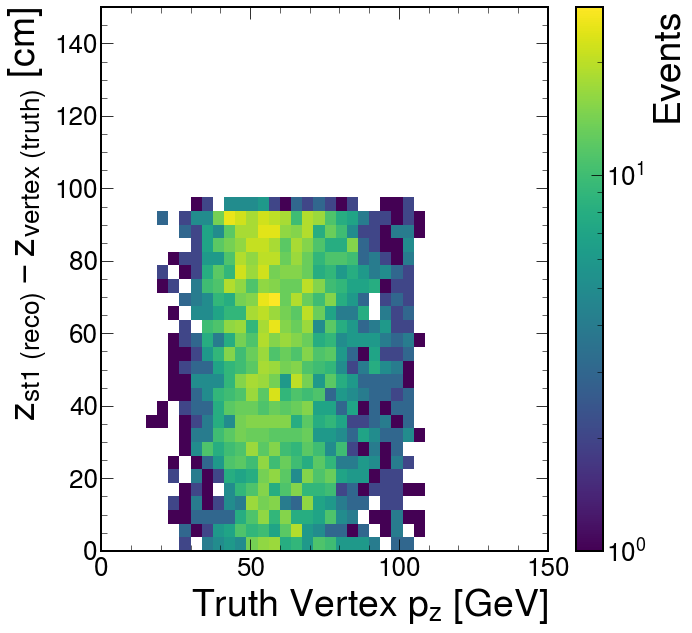

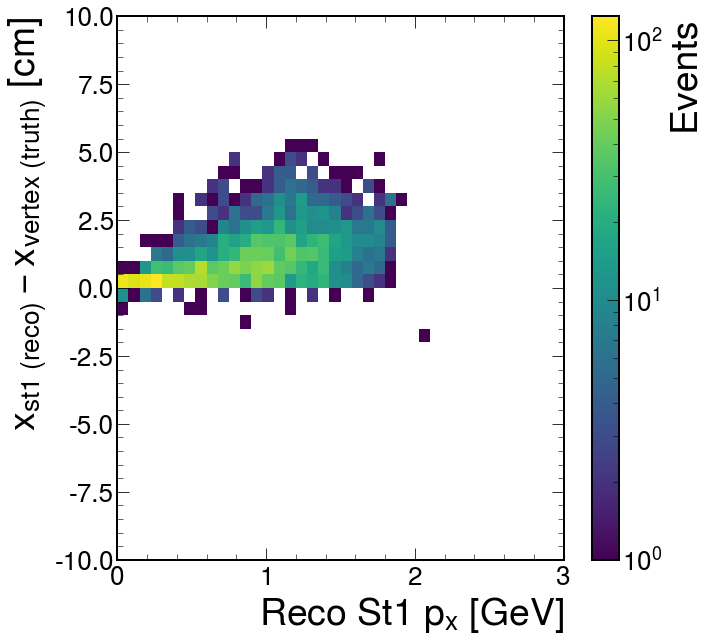

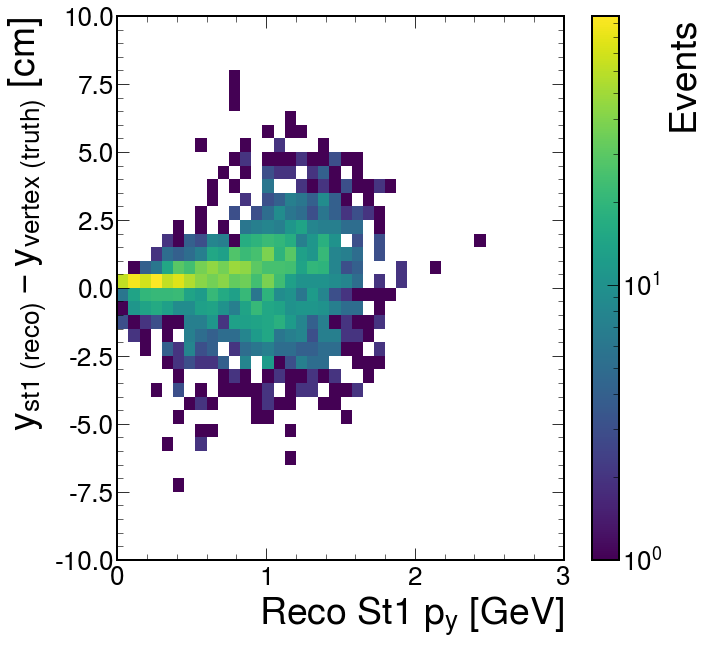

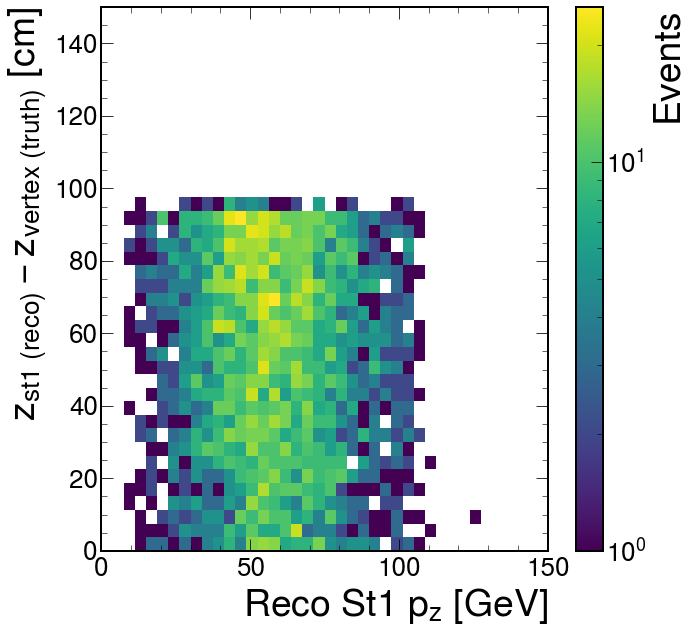

In [4]:
hist.plot2d(hists["x_ratio_truth"], xaxis = 'px', patch_opts={'norm':colors.LogNorm()})
plt.show()

hist.plot2d(hists["y_ratio_truth"], xaxis = 'py', patch_opts={'norm':colors.LogNorm()})
plt.show()

hist.plot2d(hists["z_ratio_truth"], xaxis = 'pz', patch_opts={'norm':colors.LogNorm()})
plt.show()

#RECO
hist.plot2d(hists["x_ratio_reco"], xaxis = 'px', patch_opts={'norm':colors.LogNorm()})
plt.show()

hist.plot2d(hists["y_ratio_reco"], xaxis = 'py', patch_opts={'norm':colors.LogNorm()})
plt.show()

hist.plot2d(hists["z_ratio_reco"], xaxis = 'pz', patch_opts={'norm':colors.LogNorm()})
plt.show()

## Comparing vertex position and station 1 hit

Text(0, 1, 'Counts')

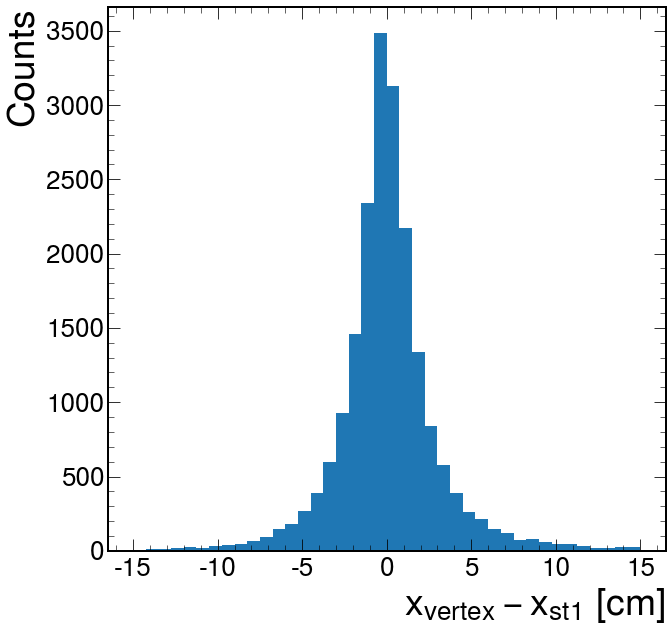

In [9]:
plt.hist(ak.flatten(dq_events["GenVertex"]["vx"] - dq_events["GenP_St1"]["hit_x"]),
         bins=40, range=(-15,15), density=False)
plt.xlabel(r"$x_{vertex} - x_{st1}$ [cm]")
plt.ylabel("Counts")

Text(0, 1, 'Counts')

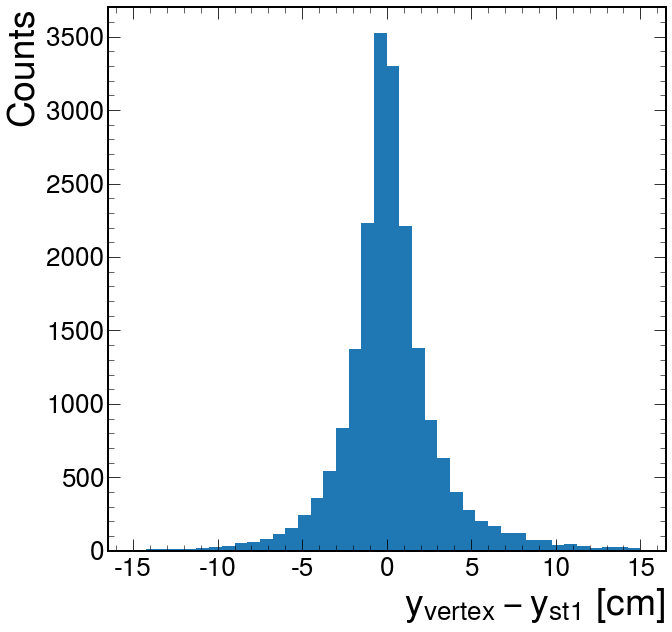

In [10]:
plt.hist(ak.flatten(dq_events["GenVertex"]["vy"] - dq_events["GenP_St1"]["hit_y"]),
         bins=40, range=(-15,15), density=False)
plt.xlabel(r"$y_{vertex} - y_{st1}$ [cm]")
plt.ylabel("Counts")

Text(0, 1, 'Counts')

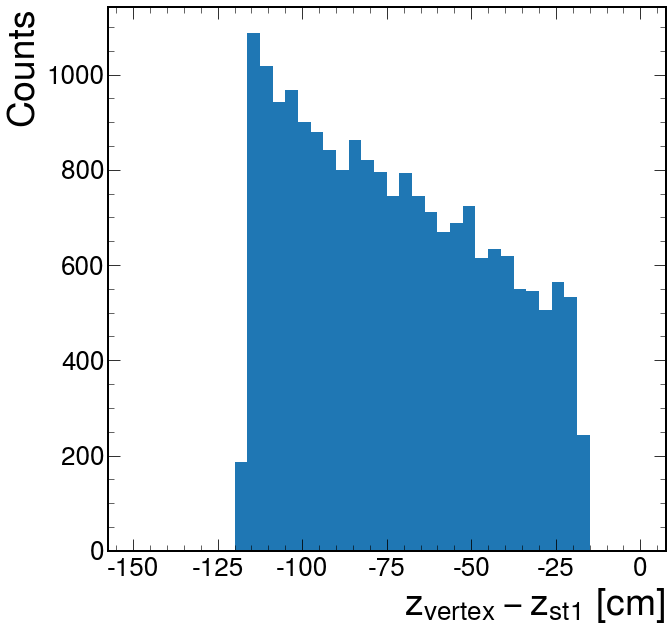

In [14]:
plt.hist(ak.flatten(dq_events["GenVertex"]["vz"] - dq_events["GenP_St1"]["hit_z"]),
         bins=40, range=(-150,0), density=False)
plt.xlabel(r"$z_{vertex} - z_{st1}$ [cm]")
plt.ylabel("Counts")

## Ratio of change in position and px

In [2]:
hists = {}
hists["x_z"] = hist.Hist("Events",
                             hist.Bin("x", r"$x_{vertex}$ [cm]", 40, 0, 20),
                             hist.Bin("z", r"$z_{vertex}$ [cm]" , 40, 500, 600))

hists["y_z"] = hist.Hist("Events",
                             hist.Bin("y",  r"$y_{vertex}$ [cm]" , 40, 0, 20),
                             hist.Bin("z", r"$z_{vertex}$ [cm]" , 40, 500, 600))
hists["x_y"] = hist.Hist("Events",
                             hist.Bin("x", r"$x_{vertex}$ [cm]", 40, 0, 20),
                             hist.Bin("y",  r"$y_{vertex}$ [cm]" , 40, 0, 20))

hists["x_ratio"] = hist.Hist("Events",
                             hist.Bin("x_residual", r"$x_{st1} - x_{vertex}$ [cm]", 40, 0, 20),
                             hist.Bin("px", r"Truth Vertex $p_x$ [GeV]" , 40, 0, 3))
hists["y_ratio"] = hist.Hist("Events",
                             hist.Bin("y_residual", r"$y_{st1} - y_{vertex}$ [cm]", 40, 0, 20),
                             hist.Bin("py", r"Truth Vertex $p_y$ [GeV]" , 40, 0, 3))
hists["z_ratio"] = hist.Hist("Events",
                             hist.Bin("z_residual", r"$z_{st1} - z_{vertex}$ [cm]", 40, 0, 150),
                             hist.Bin("pz", r"Truth Vertex $p_z$ [GeV]" , 40, 0, 150))

def ratio_processor(dq_events):
    
    
    #Select the event
    truth_vertex = dq_events["GenVertex"]
    truth_station_hit = dq_events["GenP_St1"]
    
    #Define
    hists["x_ratio"].fill(x_residual = ak.flatten(truth_station_hit.x - truth_vertex.x),
                         px = ak.flatten(truth_vertex.px))
    hists["y_ratio"].fill(y_residual = ak.flatten(truth_station_hit.y - truth_vertex.y),
                         py = ak.flatten(truth_vertex.py))
    hists["z_ratio"].fill(z_residual = ak.flatten(truth_station_hit.z - truth_vertex.z),
                         pz = ak.flatten(truth_vertex.pz))
    
    hists["x_z"].fill(x = ak.flatten(truth_vertex.x), z = ak.flatten(truth_vertex.z))
    hists["y_z"].fill(y = ak.flatten(truth_vertex.y), z = ak.flatten(truth_vertex.z))
    hists["x_y"].fill(x = ak.flatten(truth_vertex.x), y = ak.flatten(truth_vertex.y))

In [3]:
ratio_processor(dq_events)

/seaquest/users/dhoang/miniconda3/envs/Dimuon/lib/python3.8/site-packages/coffea/hist/hist_tools.py:507: RuntimeWarning: overflow encountered in multiply
  idx = numpy.clip(numpy.floor((identifier - self._lo) * float(self._bins) / (self._hi - self._lo)) + 1, 0, self._bins + 1)


<AxesSubplot:xlabel='$x_{st1} - x_{vertex}$ [cm]', ylabel='Truth Vertex $p_x$ [GeV]'>

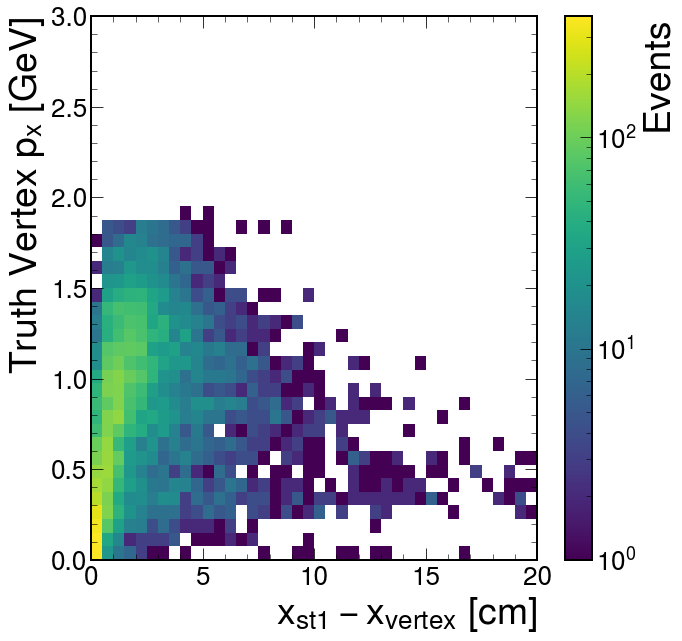

In [4]:
hist.plot2d(hists["x_ratio"], xaxis = 'x_residual', patch_opts={'norm':colors.LogNorm()})

<AxesSubplot:xlabel='$y_{st1} - y_{vertex}$ [cm]', ylabel='Truth Vertex $p_y$ [GeV]'>

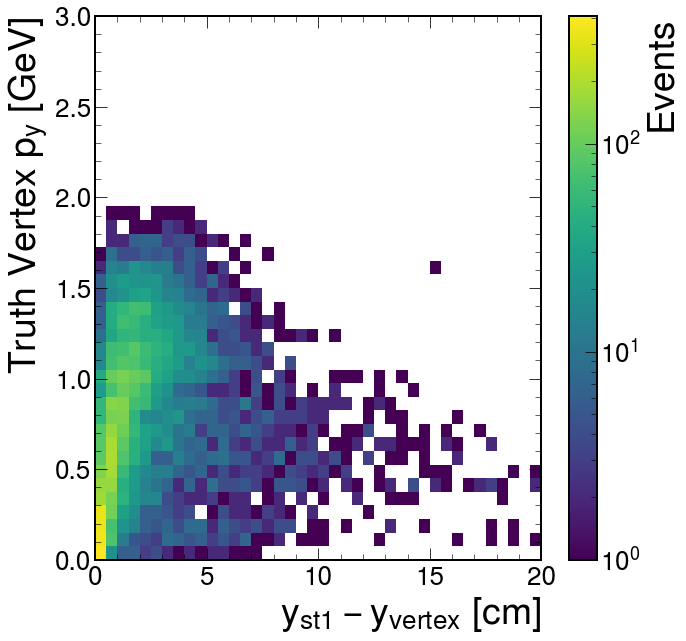

In [5]:
hist.plot2d(hists["y_ratio"], xaxis = 'y_residual', patch_opts={'norm':colors.LogNorm()})

<AxesSubplot:xlabel='$z_{st1} - z_{vertex}$ [cm]', ylabel='Truth Vertex $p_z$ [GeV]'>

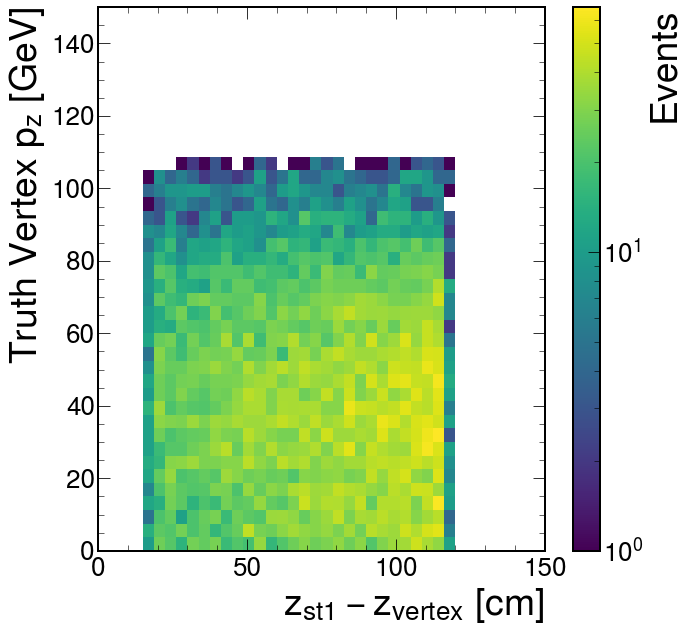

In [6]:
hist.plot2d(hists["z_ratio"], xaxis = 'z_residual', patch_opts={'norm':colors.LogNorm()})

<AxesSubplot:xlabel='$z_{vertex}$ [cm]', ylabel='$x_{vertex}$ [cm]'>

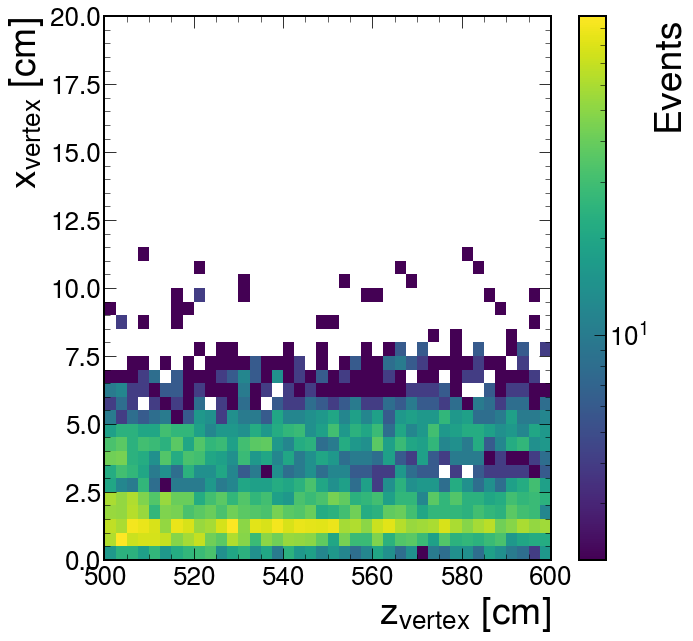

In [4]:
hist.plot2d(hists["x_z"], xaxis = "z", patch_opts={'norm':colors.LogNorm()})

<AxesSubplot:xlabel='$z_{vertex}$ [cm]', ylabel='$y_{vertex}$ [cm]'>

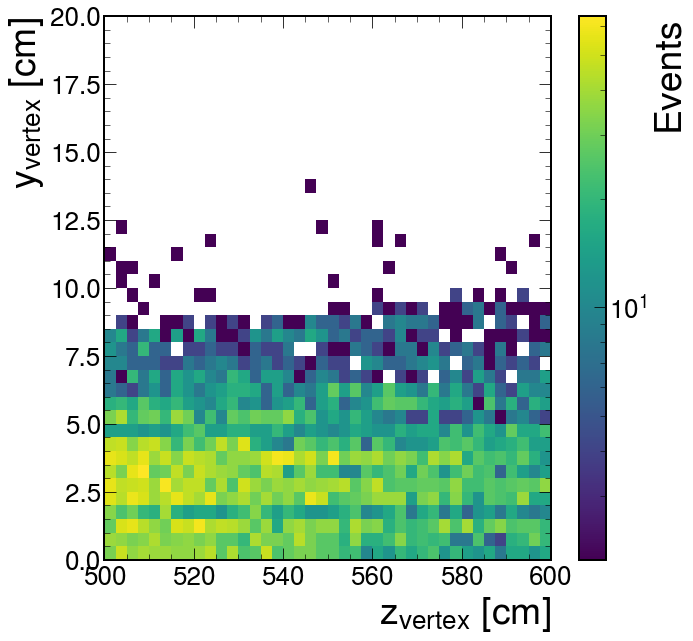

In [6]:
hist.plot2d(hists["y_z"], xaxis = "z", patch_opts={'norm':colors.LogNorm()})

<AxesSubplot:xlabel='$x_{vertex}$ [cm]', ylabel='$y_{vertex}$ [cm]'>

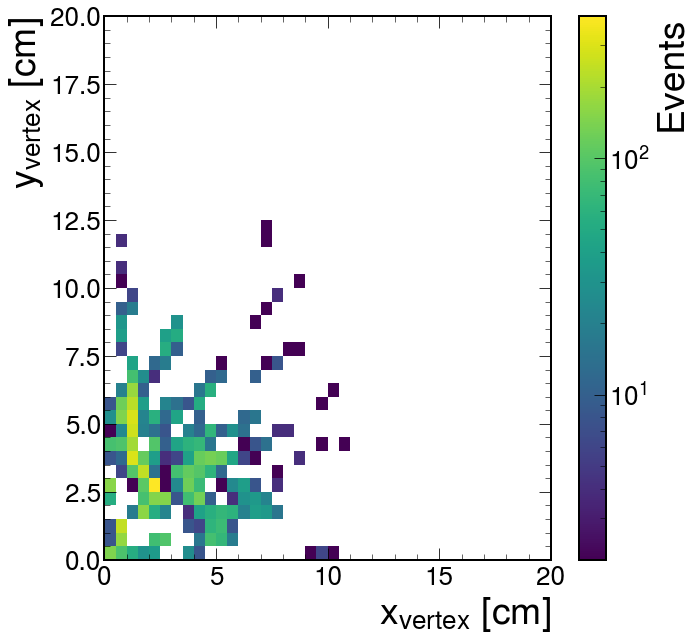

In [8]:
hist.plot2d(hists["x_y"], xaxis = "x", patch_opts={'norm':colors.LogNorm()})

## 2. Reco-ed track position at station1

## 3. Truth track momentum at station1

## 4. Truth track hits at station1

## 5. Truth track momentum at the vertex (i.e., where A’ decays)

should be pretty similar (or almost the same as) the truth track momentum at station1.

## 6.  Truth vertex position, i.e., where A’ decays. (Our target for the displaced vtx reconstruction.)